In [1]:
ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [3]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [56]:
#pip install fitsio

In [4]:
dark_frame = []
for i in range(10):
    filename = f'{ownerpath}/Lab 2/Darks/HAT_P_16_VISIBLE_DARK_20S_.0000000{i}.DARK.FIT'
    dark_f = fits.getdata(filename)
    dark_frame.append(dark_f)

In [5]:
master_dark_data = np.median(dark_frame, axis=0)

In [6]:
dark_frame_3 = []
for i in range(5):
    filename = f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Picture of Object/Andromena/Dark/Andromeda_Visible_Dark_3s_.0000000{i}.DARK.FIT'
    dark_f3 = fits.getdata(filename)
    dark_frame_3.append(dark_f3)

In [7]:
master_dark_data3 = np.median(dark_frame_3, axis=0)

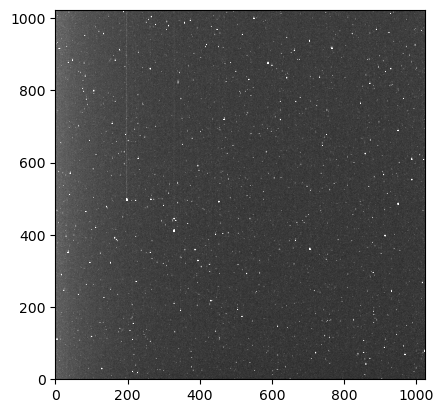

In [47]:
plt.imshow(master_dark_data3, cmap='gray', vmax=np.mean(master_dark_data3)+(np.std(master_dark_data3)), origin='lower')

In [8]:
file_num=[1,2,3,4,5,6,7,8,9]
flat_fields_data=[]

for i in range(len(file_num)):
    field_file=f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/flat_0C_2s_visible_.0000000{i}.FLAT.FIT'
    field_file_data=fits.open(field_file)
    flat_fields_data.append(field_file_data[0].data)

# Compute the median flat field
median_flat_field = np.median(flat_fields_data, axis=0)

In [9]:
# Normalizing the flat field
master_flat_field=(median_flat_field-master_dark_data3)/np.max(median_flat_field)


In [ ]:
master_flat = fits.getdata(f'{ownerpath}/Lab 1 CCD/Group 5 data lab1/Photometry/Flats/Normalized_Master_Flat-Field.FIT')

#master_flat_n = (master_flat - master_dark_data)
#master_flat_normalized = master_flat_n / np.median(master_flat_n)

In [10]:
science_files = []

for i in range(194):
    if i < 10:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.0000000{i}.FIT'
    elif i < 100 :
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.000000{i}.FIT'
    else:
        filename = f'{ownerpath}/Lab 2/Transient/HAT_P_16_VISIBLE_LIGHT_20S_.00000{i}.FIT'
    science_data = fits.getdata(filename)
    science_files.append(science_data)

In [11]:
calibrated_science_withflat = []
for i in range(194):
    science_corrected = (science_files[i] - master_dark_data)/master_flat_field
    calibrated_science_withflat.append(science_corrected)

    output_file_with = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    hdu = fits.PrimaryHDU(science_corrected)
    hdu.writeto(output_file_with, overwrite=True)

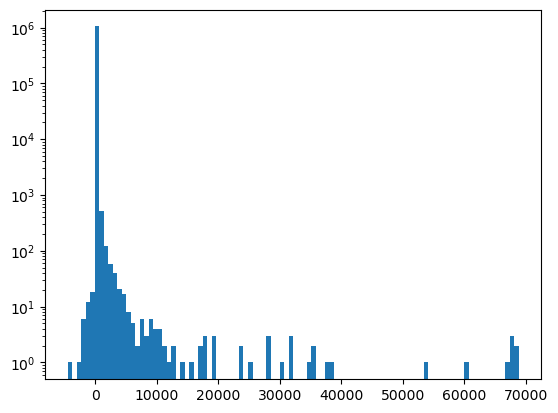

In [12]:
flatten_cal_science=calibrated_science_withflat[0].flatten()
plt.hist(flatten_cal_science, bins=100)
plt.yscale('log')

In [ ]:
# calibrated_science_withflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_with =  science_corrected / master_flat
#     calibrated_science_withflat.append(calibrated_data_with)

#     output_file_with = f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_with)
#     hdu.writeto(output_file_with, overwrite=True)

In [ ]:
# calibrated_science_withoutflat = []
# for i in range(194):
#     science_corrected = science_files[i] - master_dark_data
#     calibrated_data_without =  science_corrected / np.mean(science_corrected)
#     calibrated_science_withoutflat.append(calibrated_science_withoutflat)

#     output_file_without = f'{ownerpath}/Lab 2/Subtracted Transient(withoutflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
#     hdu = fits.PrimaryHDU(calibrated_data_without)
#     hdu.writeto(output_file_without, overwrite=True)

In [ ]:
# data = fits.getdata(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.0.fits')   
# mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
# print(np.array((mean, median, std)))  

In [21]:
# mean, median, std = sigma_clipped_stats(calibrated_science_withflat[0], sigma=3.0)  
# print(np.array((mean, median, std))) 

[248.38998673 248.27127572  15.04731646]


In [22]:
# daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)  
# sources = daofind(calibrated_science_withflat[0] - median)  
# for col in sources.colnames:  
#     if col not in ('id', 'npix'):
#         sources[col].info.format = '%.2f'  
# sources.pprint(max_width=76)  
# sources.write(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii', overwrite=True)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    307.29     17.53      0.91       0.09 ... 0.00  137.22  1.92 -0.71
  2    974.33     30.23      0.54       0.22 ... 0.00   62.05  1.38 -0.35
  3    453.31     35.35      0.82      -0.03 ... 0.00   95.54  1.48 -0.43
  4    488.44     40.14      0.55       0.31 ... 0.00   53.06  1.12 -0.12
  5    323.26     59.80      0.86       0.25 ... 0.00  129.81  1.98 -0.74
  6    435.31     77.48      0.94      -0.17 ... 0.00  162.06  2.30 -0.90
  7     39.27    167.40      0.76      -0.09 ... 0.00 2198.05 35.64 -3.88
  8      8.31    180.77      0.76      -0.28 ... 0.00   59.53  1.03 -0.04
  9    885.40    216.41      0.98      -0.02 ... 0.00 2992.52 39.91 -4.00
 10    934.33    219.34      0.97      -0.37 ... 0.00   96.22  1.27 -0.26
...       ...       ...       ...        ... ...  ...     ...   ...   ...
 58     85.99    892.53      0.60     

In [ ]:
# dir(DAOStarFinder)

In [12]:
def show_image(data, cmap='gray'):
    """
    Displays an image using the mean and standard deviation for contrast scaling.

    Parameters:
    - data: 2D numpy array, the image data to be displayed.
    - cmap: str, the colormap to be used for displaying the image (default is 'gray').

    Returns:
    - None
    """
    # Calculate the min and max values for display scaling
    mi = np.mean(data) - np.std(data)
    ma = np.mean(data) + 2*np.std(data)
    
    # Display the image with the specified scaling
    plt.imshow(data, cmap=cmap, origin='lower', vmin=mi, vmax=ma)
    plt.colorbar()
    plt.show()

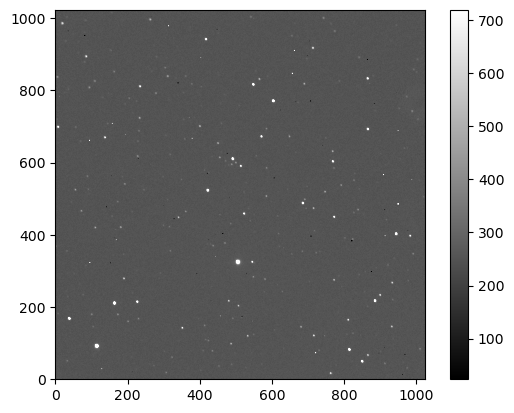

255.47273504528386


In [13]:
# norm = simple_norm(calibrated_science_withflat[0], 'sqrt')

# positions = np.transpose((426.9475, 798.2625))
# apertures = CircularAperture(positions, r=5.0)
#apertures.plot(color='blue', lw=1.5, alpha=0.5)

show_image(calibrated_science_withflat[0])
print(np.mean(calibrated_science_withflat[0]))

In [163]:
good_frames=[]
for i in range(len(calibrated_science_withflat)):
        if np.mean(calibrated_science_withflat[i])<300:
            good_frames.append([calibrated_science_withflat[i]])
            print(np.mean(calibrated_science_withflat[i]))

255.47273504528386
255.03353455068535
254.91020309521517
252.89504597569675
251.0264978062323
251.6801497570081
252.11492689318536
254.58856478651416
253.44232093132393
252.80492076508165
252.24639054919706
253.0719565519303
253.7047340400001
252.00116785778303
252.9276972794943
255.460363056205
254.35443605145255
256.91702849175215
254.89484053327894
254.62686875913215
253.68933577339953
256.0538118578841
256.7182981860944
258.2279917388413
260.8410919602533
261.9061116678273
251.2313992052915
252.89615452630667
250.28473498662086
265.4310982279157
277.51173310759737
259.9950943186133
256.788732914139
263.58929586138674
265.57181671475695
262.6742892895711
272.3286446958635
282.7532028322931
277.21967000251334
262.8490318826862
268.49226164495076
263.0911694678194
255.60746814000356
252.88733814498676
267.9383047946953
265.83346398828394
268.94145909288403
262.52830714642266
274.13678938888415
275.2035266030622
259.87667069628066
255.82209826945595
252.22003989890396
279.7293448994678

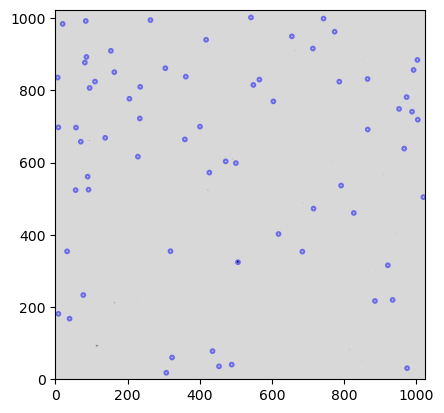

In [24]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(calibrated_science_withflat[0], cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [ ]:
# ast = AstrometryNet()
# ast.api_key = 'zxdmyndauvanohii'

# sources = Table.read(f'{ownerpath}/Lab 2/Subtracted Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

In [36]:
# ast = AstrometryNet()
# ast.api_key = 'kwbavttkhitkoaeo'

# sources = Table.read(f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/sources.txt', format='ascii')
# # Sort sources in ascending order
# sources.sort('flux')
# # Reverse to get descending order
# sources.reverse()

# image_width = 1024
# image_height = 1024
# wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
#                                         image_width, image_height, solve_timeout=120)

Solving.......................................................................................

In [37]:
# wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        9.68152412307 / RA  of reference point                         
CRVAL2  =        42.4411103366 / DEC of reference point                         
CRPIX1  =             426.94

In [183]:
aligned_images = []

for i in range(len(good_frames)):
    aligned_file=f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits'
    aligned_file_data=fits.getdata(aligned_file)
    aligned_file_data = aligned_file_data.byteswap(inplace=True).newbyteorder()
    aligned_images.append(aligned_file_data)

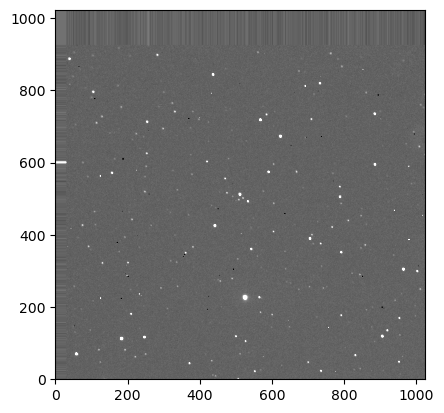

In [184]:
plt.imshow(aligned_images[25], cmap='gray', origin='lower', vmin=100, vmax=500)

In [185]:
(aligned_images[0]).shape

(1024, 1024)

In [186]:
# Define the cropping coordinates
x_min, x_max = 200, 800
y_min, y_max = 200, 800

#fig = plt.figure(figsize=(18, 3))  # width, height in inches
cropped_aligned_frames=[]

#Plot each flat frame
for i in range(len(aligned_images)):
        # Crop the image
    cropped_aligned_frames.append(aligned_images[i][y_min:y_max, x_min:x_max])

In [196]:
#remove background

cropped_bkgsub=[]
cbkg_rms=[]

for i in range(len(cropped_aligned_frames)):
    bkg = sep.Background(np.ascontiguousarray(cropped_aligned_frames[i]), bw=100, bh=100)
    cbkg_rms.append(bkg.globalrms)
    cropped_bkgsub.append(cropped_aligned_frames[i]-bkg)

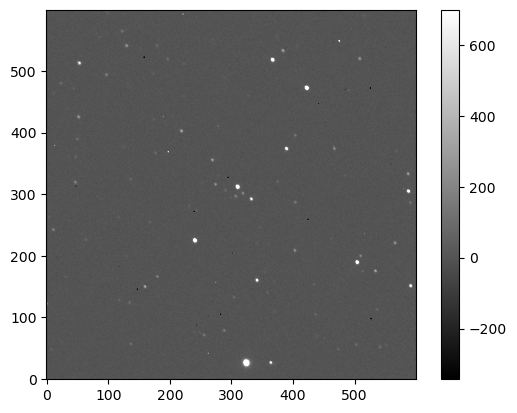

13.680543899536133


In [216]:
show_image(cropped_bkgsub[0])
print(cbkg_rms[55])

In [199]:
#extract objects from frame

frame_objects=[]
for i in range(len(cropped_bkgsub)):
    objects = sep.extract(cropped_bkgsub[i], 12, err=cbkg_rms[i])
    frame_objects.append(objects)

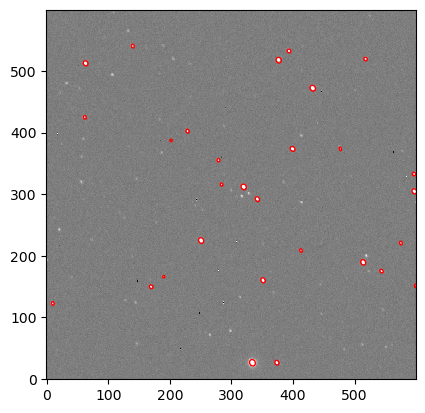

In [271]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(cropped_bkgsub[20]), np.std(cropped_bkgsub[20])
im = ax.imshow(cropped_bkgsub[20], interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(frame_objects[20])):
    e = Ellipse(xy=(frame_objects[20]['x'][i], frame_objects[20]['y'][i]),
                width=6*frame_objects[20]['a'][i],
                height=6*frame_objects[20]['b'][i],
                angle=frame_objects[20]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [205]:
#Extract flux and flux error

fluxes=[]
flux_err=[]
flags=[]

for i in range(len(cropped_bkgsub)):
    flux, fluxerr, flag = sep.sum_circle(cropped_bkgsub[i], frame_objects[i]['x'], frame_objects[i]['y'],
                                     6.6, err=cbkg_rms[i], gain=2.0)
    fluxes.append(flux)
    flux_err.append(fluxerr)
    flags.append(flag)

In [291]:
for i in range(len(frame_objects[0]['x'])):
    print(i,"object {:.3f} {:.3f}: flux = {:f} +/- {:f}".format(frame_objects[0]['x'][i],frame_objects[0]['y'][i], fluxes[0][i], flux_err[0][i]))

0 object 364.063 26.244: flux = 12822.357839 +/- 162.284440
1 object 324.429 26.162: flux = 1028592.752000 +/- 730.880641
2 object 0.927 122.044: flux = 3748.240391 +/- 120.656279
3 object 160.307 149.421: flux = 5746.997133 +/- 151.011192
4 object 590.887 150.749: flux = 15609.247766 +/- 166.504846
5 object 341.733 159.822: flux = 18102.661243 +/- 170.224532
6 object 180.191 165.805: flux = 2934.049636 +/- 146.021349
7 object 533.920 174.755: flux = 5492.582674 +/- 150.608744
8 object 504.173 189.083: flux = 38684.409177 +/- 198.159696
9 object 403.143 208.293: flux = 4313.459362 +/- 148.560252
10 object 565.645 220.376: flux = 4721.994750 +/- 149.246160
11 object 241.096 224.459: flux = 67842.373525 +/- 231.997767
12 object 11.428 241.803: flux = 3303.429085 +/- 146.731754
13 object 332.564 291.566: flux = 13848.791802 +/- 163.786974
14 object 318.869 300.889: flux = 3600.250167 +/- 147.414405
15 object 587.425 304.192: flux = 21971.281588 +/- 175.681911
16 object 310.363 311.430: fl

In [270]:
len(frame_objects)

65

In [266]:
for i in range(len(fluxes)):
    for j in range(len(fluxes[i])):
        if frame_objects[i]['x'][j] > 309 and frame_objects[i]['x'][j] <320:
            if frame_objects[i]['y'][j] > 309 and frame_objects[i]['y'][j] <315:
                print(i, frame_objects[i]['x'][j], frame_objects[i]['y'][j], fluxes[i][j], flux_err[i][j])

0 310.36254212824815 311.43026590884756 70342.9048572135 234.6396526351908
1 310.7066366389083 311.3457784499503 70509.9660329223 245.5969097056974
2 311.1787561285985 312.463376762157 69619.28609740974 243.7963737487212
3 310.7205457993945 311.35783291386747 70687.56469911811 231.52668420766065
4 310.20720526149455 311.7212972162664 70478.40879920065 245.39817119722812
5 310.7300748244449 312.08733627982184 70241.04069465786 243.60122063124408
6 311.10866155980204 311.6355322365408 70223.87025358142 243.8971899739342
7 310.85589371398623 311.5227435505936 70272.34015686391 240.18088096803697
8 311.63644961014745 312.01466202740323 70114.99909323096 234.481467715231
9 311.1987659226981 311.4930424663143 70614.72611546189 231.51253080564697
10 310.71900932782376 311.82099275682083 69833.46569200518 249.87649228208107
11 311.08267048816964 311.70208621998074 70315.48777962447 235.81197101217987
12 310.65193103749993 311.52211411629224 69219.3869608748 235.48118003640087
13 311.6544873226

In [292]:
for i in range(len(fluxes)):
    for j in range(len(fluxes[i])):
        if fluxes[i][j] > 9500 and fluxes[i][j] <100000:
            if not host_planet['flux'][i]==fluxes[i][j]:
                 print(i, frame_objects[i]['x'][j], frame_objects[i]['y'][j], fluxes[i][j], flux_err[i][j])

0 364.06343908891415 26.24398122548801 12822.357838852262 162.28444048950757
0 590.887284223094 150.74937118644857 15609.247765750886 166.5048457354418
0 341.73256442580254 159.8215211629472 18102.66124319986 170.22453209560112
0 504.17260915898584 189.08264120569464 38684.40917699679 198.15969644219987
0 241.09645611674853 224.45864415057432 67842.37352453024 231.99776664355446
0 332.5636836117778 291.5657110773418 13848.791801755426 163.78697404314465
0 587.4250877066603 304.1918928565081 21971.281587603684 175.68191147326323
0 389.62972865534994 373.2187534364324 21726.718693609837 175.3667426909098
0 422.4193316493051 471.79663795614584 62594.14594631791 226.19443920693416
0 53.639601044369776 511.9608832115566 14286.426893877388 164.4890035302905
0 367.1413258463964 517.3109336011171 35033.95166320025 193.46936363943865
1 364.43831894218425 26.183326719489635 12937.70812820017 177.53045019440748
1 591.2170704528319 150.7495440333188 15835.442708379103 181.565217033215
1 342.073894

In [272]:


def extract_flux_table(frame_objects, fluxes, flux_err, x_min, x_max, y_min, y_max):
    """
    Extracts the flux and flux error of objects within a specified pixel range and stores them in a table.

    Parameters:
    - frame_objects: list of dictionaries, where each dictionary contains 'x' and 'y' coordinates of objects in a frame.
    - fluxes: list of lists, where each sublist contains flux values for objects in a frame.
    - flux_err: list of lists, where each sublist contains flux error values for objects in a frame.
    - x_min: int, the minimum x-coordinate range.
    - x_max: int, the maximum x-coordinate range.
    - y_min: int, the minimum y-coordinate range.
    - y_max: int, the maximum y-coordinate range.

    Returns:
    - table: Astropy Table containing columns 'frame', 'x', 'y', 'flux', and 'flux_err'.
    """
    # Define lists to store the data
    frame_list = []
    x_list = []
    y_list = []
    flux_list = []
    flux_err_list = []

    # Iterate through each frame and each object's coordinates
    for i in range(len(fluxes)):
        for j in range(len(fluxes[i])):
            # Check if the object's coordinates are within the specified range
            x = frame_objects[i]['x'][j]
            y = frame_objects[i]['y'][j]
            if x_min < x < x_max and y_min < y < y_max:
                # Append the data to respective lists
                frame_list.append(i)
                x_list.append(x)
                y_list.append(y)
                flux_list.append(fluxes[i][j])
                flux_err_list.append(flux_err[i][j])

    # Create a table with the gathered data
    table = Table([frame_list, x_list, y_list, flux_list, flux_err_list], 
                  names=('frame', 'x', 'y', 'flux', 'flux_err'))

    return table

In [273]:
host_planet= extract_flux_table(frame_objects, fluxes, flux_err, 309, 320, 309, 315)

In [289]:
reference_star_1= extract_flux_table(frame_objects, fluxes, flux_err, 240, 251, 222, 226)
reference_star_2= extract_flux_table(frame_objects, fluxes, flux_err, 420, 432, 470, 474)
reference_star_3
nofr = 2

In [293]:
host_planet

frame,x,y,flux,flux_err
int32,float64,float64,float64,float64
0,310.36254212824815,311.43026590884756,70342.9048572135,234.6396526351908
1,310.7066366389083,311.3457784499503,70509.9660329223,245.5969097056974
2,311.1787561285985,312.463376762157,69619.28609740974,243.7963737487212
3,310.7205457993945,311.35783291386747,70687.56469911811,231.52668420766065
4,310.20720526149455,311.7212972162664,70478.40879920065,245.39817119722812
5,310.7300748244449,312.08733627982184,70241.04069465786,243.60122063124408
6,311.10866155980204,311.6355322365408,70223.87025358142,243.8971899739342
7,310.85589371398623,311.5227435505936,70272.34015686391,240.18088096803697
8,311.63644961014745,312.01466202740323,70114.99909323096,234.481467715231


In [ ]:
ref_flux_ = []

for i in range(nofr):
    ref_flux_.append([])  

In [ ]:
ref_flux_err_ = [] 

for i in range(nofr):
    ref_flux_err_.append([]) 

In [ ]:
mean_ref = []
for i in range(nofr):
    target_ref_star = reference_star[i]
    for j in range(len(reference_star_1)):
        target_flux = target_ref_star[j][3]
        ref_flux_[i].append(target_flux)
        
        target_flux_err = target_ref_star[j][4]
        ref_flux_err_[i].append(target_flux_err)
        
    target_mean = np.mean(ref_flux_[i])
    mean_ref.append(target_mean)

In [ ]:
mean_ref

In [ ]:
final_ref_flux_ = []

for i in range(nofr):
    final_ref_flux_.append([]) 

In [ ]:
final_ref_flux_err_ = []

for i in range(nofr):
    final_ref_flux_err_.append([]) 

In [ ]:
for i in range(nofr):
    needed_ref_flux = ref_flux_[i]
    needed_ref_flux_err = ref_flux_err_[i]
    for j in range(len(reference_star_1)):
        final_ref_flux = needed_ref_flux[j]/mean_ref[i]
        final_ref_flux_[i].append(final_ref_flux)
        
        final_ref_flux_err = needed_ref_flux_err[j]/mean_ref[i]
        final_ref_flux_err_[i].append(final_ref_flux_err) 

In [ ]:
plt.scatter(np.arange(len(fluxes)), host_planet['flux'])
plt.scatter(np.arange(len(fluxes)), reference_star_1['flux'])
plt.scatter(np.arange(len(fluxes)), reference_star_2['flux'])

In [264]:
def align_images(images, star_coords, center_coords):
    aligned_images = []

    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)

    return aligned_images

In [273]:
def save_aligned_images(aligned_images, ownerpath):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(f'{ownerpath}/Lab 2/Aligned Images/aligned_HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits', overwrite=True)

In [274]:
# Define paths
input_directory = f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/'
output_directory = f'{ownerpath}/Lab 2/Aligned Images/'

# List of your FITS files with full paths
filenames = [f'{ownerpath}/Lab 2/Calibrated Transient(withflat)/HAT_P_16_VISIBLE_LIGHT_20S_.{i}.fits' for i in [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31,
    33, 37, 38, 39, 42, 43, 59, 63, 70, 71, 72, 75, 84, 85,
    86, 89, 91, 93, 94, 95, 102, 103, 104, 107, 108, 109,
    111, 112, 114, 115, 116, 118, 120, 121, 122, 126
]]


# Star coordinates in each image
star_coords = [
    (493.338, 609.667), (490.2, 613.8), (501, 595.338), (498.6, 600.6),
    (496.2, 604.2), (513, 577.338), (540, 535.338), (537.2, 539.667),
    (533.338, 543.338), (530.5, 548.338), (528, 552.2), (524.667, 556.3),
    (522.2, 560.5), (518.338, 564.667), (516.3, 568.338), (513, 572.2),
    (510.5, 575.5), (507.2, 579.667), (503.338, 583.5), (501, 587.2),
    (489, 590.5), (494.667, 594.667), (492.2, 598.338), (488.338, 602.2),
    (485.5, 606.3), (482.2, 610.5), (473, 621.3), (470.5, 624.667),
    (466.338, 628.5), (463.338, 632.2), (457.2, 639.667), (445, 653.338),
    (441.667, 657.338), (438.667, 660.5), (429.667, 670.667), (426, 674.338),
    (410, 671.667), (396.833, 683.5), (438, 605.5), (434.667, 608),
    (431.3, 610.5), (419.667, 619.667), (386.3, 644.667), (382.167, 647.2),
    (378.833, 650.5), (368, 658), (359.667, 663.883), (352.2, 669.667),
    (348.833, 673), (344.667, 675.5), (316, 696.3), (312.2, 698.833),
    (308.5, 701.883), (394.3, 561.833), (443.833, 485.5), (492.2, 408.833),
    (484.667, 413), (481.3, 414.667), (473, 418.833), (469.667, 421.3),
    (466.3, 423), (458, 427.2), (450.5, 432.2), (446.3, 433.833),
    (442.2, 436.3), (425.5, 44.667)]

In [275]:
# Center of the image
center_coords = (512, 512)  # For a 1024x1024 image

# Function to load images
def load_fits_images(filepaths):
    return [fits.getdata(fp) for fp in filepaths]

# Function to align images
def align_images(images, star_coords, center_coords):
    aligned_images = []
    for img, (star_x, star_y) in zip(images, star_coords):
        x_offset = center_coords[0] - star_x
        y_offset = center_coords[1] - star_y
        aligned_img = shift(img, shift=(y_offset, x_offset), mode='nearest')
        aligned_images.append(aligned_img)
    return aligned_images

# Function to save aligned images
def save_aligned_images(aligned_images, output_directory, base_name):
    for i, aligned_img in enumerate(aligned_images):
        hdu = fits.PrimaryHDU(aligned_img)
        hdu.writeto(os.path.join(output_directory, f"{base_name}.{i}.fits"), overwrite=True)

# Load images
filepaths = [os.path.join(input_directory, fname) for fname in filenames]
images = load_fits_images(filepaths)

# Align images
aligned_images = align_images(images, star_coords, center_coords)

# Save aligned images
save_aligned_images(aligned_images, output_directory, "aligned_HAT_P_16_VISIBLE_LIGHT_20S_")

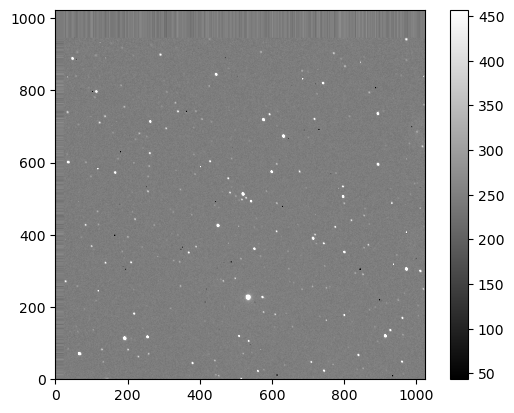

In [283]:
plt.imshow(aligned_images[20], cmap='gray', origin='lower', vmin=np.mean(aligned_images[0])-np.std(aligned_images[0]), vmax=np.mean(aligned_images[0])+np.std(aligned_images[0]))
plt.colorbar()
plt.show()